In [1]:
from logging import getLogger
import traceback
import argparse
import os
import pandas as pd
import ollama
import chromadb
import requests
from reportparse.structure.document import Document
import re
from reportparse.db_rag.db import ChromaDBHandler
from langchain_groq import ChatGroq
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json

logger = getLogger(__name__)

# Load document
document = Document.from_json_file('./results/example.pdf.json')


df = document.to_dataframe_ext(level='page')
print(df)
print()

      page_id  page_num   page_width  page_height  \
0  page_idx_0         0  4405.499776  2480.316671   
1  page_idx_1         1  4405.499776  2480.316671   
2  page_idx_2         2  4405.499776  2480.316671   
3  page_idx_3         3  4405.499776  2480.316671   
4  page_idx_4         4  4405.499776  2480.316671   
5  page_idx_5         5  4405.499776  2480.316671   

                                           page_text  \
0  049 Hitachi Sustainability Report 2023 Environ...   
1  050 Hitachi Sustainability Report 2023 Environ...   
2  051 Hitachi Sustainability Report 2023 Environ...   
3  052 Hitachi Sustainability Report 2023 Environ...   
4  053 Hitachi Sustainability Report 2023 Environ...   
5  054 Hitachi Sustainability Report 2023 Environ...   

                                          First pass  \
0  Company Name: Hitachi Ltd.\n\nPotential greenw...   
1  Company Name: Hitachi\nPotential greenwashing ...   
2  Company Name: Hitachi\nPotential greenwashing ...   
3  Company 

In [2]:
print(df.columns)


Index(['page_id', 'page_num', 'page_width', 'page_height', 'page_text',
       'First pass', 'meta_First pass_info', 'chroma_result_claim_0',
       'meta_chroma_result_claim_0_claim',
       'meta_chroma_result_claim_0_retrieved_pages',
       'meta_chroma_result_claim_0_label',
       'meta_chroma_result_claim_0_justification', 'aggregator_result_claim_0',
       'meta_aggregator_result_claim_0_claim',
       'meta_aggregator_result_claim_0_chroma_result',
       'meta_aggregator_result_claim_0_web_rag_result',
       'meta_aggregator_result_claim_0_label',
       'meta_aggregator_result_claim_0_justification',
       'meta_aggregator_result_claim_0_cti metrics_detection',
       'meta_aggregator_result_claim_0_cti metrics_commitment',
       'meta_aggregator_result_claim_0_cti metrics_sentiment',
       'meta_aggregator_result_claim_0_cti metrics_specificity',
       'chroma_result_claim_1', 'meta_chroma_result_claim_1_claim',
       'meta_chroma_result_claim_1_retrieved_pages',
   

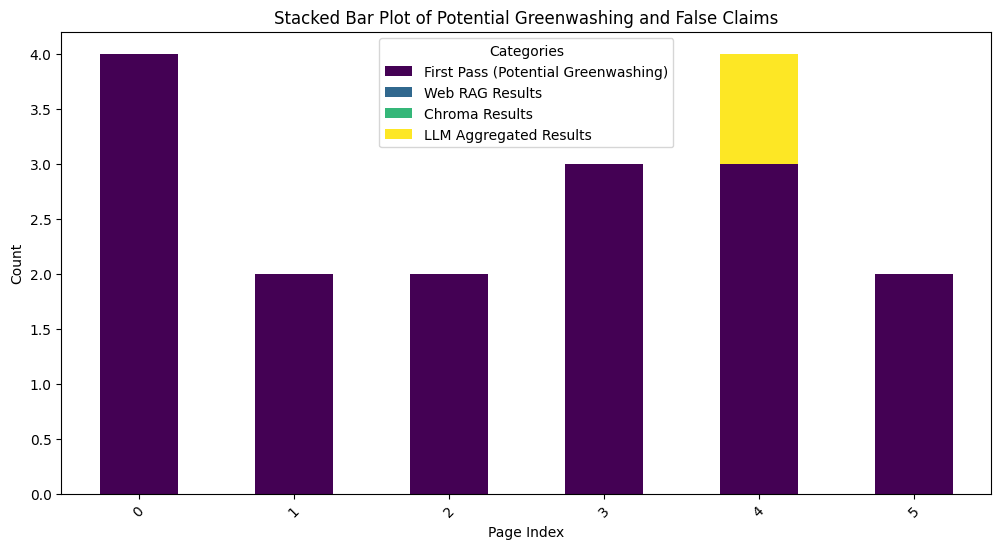

In [ ]:
# Count occurrences of "Potential greenwashing" in the "First pass" column per page
first_pass_count = df["first_pass"].str.count("Potential greenwashing", flags=re.IGNORECASE).groupby(df.index).sum()

def count_false_statements(columns, df):
    return df[columns].apply(lambda col: col.str.contains("Result of the statement: PARTIALLY FALSE|Result of the statement: FALSE", na=False)).sum(axis=1)

# **Dynamically find relevant columns** for each category
web_rag_columns = [col for col in df.columns if col.startswith("web_rag_result")]
chroma_columns = [col for col in df.columns if col.startswith("chroma_result")]
aggregator_columns = [col for col in df.columns if col.startswith("aggregator_result")]

# Count false claims for each category
web_rag_count = count_false_statements(web_rag_columns, df)
chroma_count = count_false_statements(chroma_columns, df)
llm_agg_count = count_false_statements(aggregator_columns, df)

# Create DataFrame for plotting
plot_df = pd.DataFrame({
    "First Pass (Potential Greenwashing)": first_pass_count,
    "Web RAG Results": web_rag_count,
    "Chroma Results": chroma_count,
    "LLM Aggregated Results": llm_agg_count
})

# Plot stacked bar chart
ax = plot_df.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.xlabel("Page Index")
plt.ylabel("Count")
plt.title("Stacked Bar Plot of Potential Greenwashing and False Claims")
plt.legend(title="Categories")
plt.xticks(np.arange(len(plot_df.index)), plot_df.index, rotation=45)
plt.show()



In [7]:
print(df.head())  

      page_id  page_num   page_width  page_height  \
0  page_idx_0         0  4405.499776  4405.499776   
1  page_idx_1         1  4405.499776  4405.499776   
2  page_idx_2         2  4405.499776  4405.499776   
3  page_idx_3         3  4405.499776  4405.499776   
4  page_idx_4         4  4405.499776  4405.499776   

                                           page_text  \
0  049 Hitachi Sustainability Report 2023 Environ...   
1  050 Hitachi Sustainability Report 2023 Environ...   
2  051 Hitachi Sustainability Report 2023 Environ...   
3  052 Hitachi Sustainability Report 2023 Environ...   
4  053 Hitachi Sustainability Report 2023 Environ...   

                                          First pass  \
0  Company Name: Hitachi Ltd.\n\nPotential greenw...   
1  Company Name: Hitachi\nPotential greenwashing ...   
2  Company Name: Hitachi\nPotential greenwashing ...   
3  Company Name: Hitachi\nPotential greenwashing ...   
4  Company Name: Hitachi\nPotential greenwashing ...   

       

In [6]:


# climate_dict = df[]

# climate_df = df[df["climate"] == "yes"]

# cti_df = climate_df.groupby("page_id").apply(
#     lambda x: pd.Series({
#         "commit_total": (x["climate_commitment"] == "yes").sum(),
#         "commit_non_spec": ((x["climate_commitment"] == "yes") & (x["climate_specificity"] == "non")).sum()
#     })
# )

# Calculate CTI
# cti_df["CTI"] = cti_df["commit_non_spec"] / cti_df["commit_total"]
# cti_df["CTI"].fillna(0, inplace=True)

# cti_df.reset_index(inplace=True)

# print(cti_df)

# # for the whole document
# total_commit = (climate_df["climate_commitment"] == "yes").sum()
# total_commit_non_spec = ((climate_df["climate_commitment"] == "yes") & (climate_df["climate_specificity"] == "non")).sum()
# overall_cti = total_commit_non_spec / total_commit if total_commit > 0 else 0

# print(f"Overall Cheap Talk Index (CTI): {overall_cti:.4f}")

# cti_results = {
#     "page_cti_scores": cti_df.set_index("page_id")["CTI"].to_dict(),
#     "overall_cti": overall_cti
# }
# input_base = os.path.basename(args.input)
# output_path = f"./cli_results/{input_base}_cti_scrores.json"

# with open(output_path, "w") as f:
#     json.dump(cti_results, f, indent=4)

# print(f"CTI scores saved to {output_path}")


# page_ids = list(cti_results["page_cti_scores"].keys())
# page_scores = list(cti_results["page_cti_scores"].values())

# plt.figure(figsize=(12, 6))

# sns.barplot(x=page_ids, y=page_scores, palette="Blues_r")

# plt.axhline(y=overall_cti, color='red', linestyle='--', label=f'Overall CTI: {overall_cti:.4f}')

# plt.xlabel("Page ID")
# plt.ylabel("CTI Score")
# plt.title("Cheap Talk Index (CTI) per Page")
# plt.xticks(rotation=90)  
# plt.legend()

# plt.tight_layout()
# plt.show()

# # save plot in the same dir
# plt.savefig(f"./cli_results/{input_base}_cti_plot.png")

In [ ]:
# in df iloc 0 print meta_aggregator_result_claim_\d+_cti metrics_detection"
print(df.iloc[0]["meta_aggregator_result_claim_3_cti metrics_detection"])
[('yes', 0.9965571165084839)]

[('yes', 0.9965571165084839)]


In [ ]:
import pandas as pd
import re

def analyze_claims(df):
    # find cti metrics columns
    claim_cols = [col for col in df.columns if re.match(r"meta_aggregator_result_claim_\d+_cti metrics_", col)]

    results = []
    for idx, row in df.iterrows():
        # Determine how many claims exist for this page
        total_claims = len(set(re.findall(r"meta_aggregator_result_claim_(\d+)_", " ".join(claim_cols))))
        print("Marked claims", total_claims, "in page", idx)
        commitment_yes = 0
        detection_yes = 0
        non_specific_commitment_yes = 0

        for i in range(total_claims):
            detection_col = f"meta_aggregator_result_claim_{i}_cti metrics_detection"
            commitment_col = f"meta_aggregator_result_claim_{i}_cti metrics_commitment"
            specificity_col = f"meta_aggregator_result_claim_{i}_cti metrics_specificity"

            detection = row.get(detection_col, [])
            commitment = row.get(commitment_col, [])
            specificity = row.get(specificity_col, [])

            # extract the first value from tuples if they exist (tuples have both label and confidence score)
            detection_label = detection[0][0] if isinstance(detection, list) and detection else None
            commitment_label = commitment[0][0] if isinstance(commitment, list) and commitment else None
            specificity_label = specificity[0][0] if isinstance(specificity, list) and specificity else None

            if detection_label == "yes":
                detection_yes += 1

            if commitment_label == "yes":
                commitment_yes += 1
                if specificity_label == "non":
                    non_specific_commitment_yes += 1

        # Compute the fraction
        ratio = (non_specific_commitment_yes / commitment_yes) if commitment_yes > 0 else None

        results.append({
            "page_id": row["page_id"],
            "total_claims": total_claims,
            "commitment_yes": commitment_yes,
            "detection_yes": detection_yes,
            "non_specific_commitment_yes": non_specific_commitment_yes,
            "non_specific_commitment_ratio": ratio
        })

    return pd.DataFrame(results)

# Usage
summary_df = analyze_claims(df)
print(summary_df)


Marked claims 4 in page 0
Marked claims 4 in page 1
Marked claims 4 in page 2
Marked claims 4 in page 3
Marked claims 4 in page 4
Marked claims 4 in page 5
      page_id  total_claims  commitment_yes  detection_yes  \
0  page_idx_0             4               1              4   
1  page_idx_1             4               2              2   
2  page_idx_2             4               1              2   
3  page_idx_3             4               2              2   
4  page_idx_4             4               2              2   
5  page_idx_5             4               1              2   

   non_specific_commitment_yes  non_specific_commitment_ratio  
0                            1                            1.0  
1                            1                            0.5  
2                            1                            1.0  
3                            0                            0.0  
4                            2                            1.0  
5                        